In [1]:
import json
import pandas
import matplotlib

fig_width = 5
fig_height = 4
params = {
          #'backend': 'notebook',
          'text.latex.preamble': [r'\usepackage{gensymb}'],
          'axes.labelsize': 8, # fontsize for x and y labels (was 10)
          'axes.titlesize': 8,
          'font.size': 8, # was 10
          'text.usetex': False,
          'figure.figsize': [fig_width,fig_height],
          'font.family': 'serif',
          'image.cmap': "CMRmap",
}

matplotlib.rcParams.update(params)

import matplotlib.pyplot as plt
import itertools
import numpy as np

In [2]:
ss = """
{"use_cuda": false, "num_threads": 1, "use_avx": true, "memory_transfer": 2.13948814218417, "sum_in_offsets": 125.99419392931026, "simple_cut": 4939.688810188693, "max_in_offsets": 120.44624522099818, "get_in_offsets": 150.12462171188972, "mask_deltar_first": 33.91627504134458, "select_muons_opposite_sign": 127.10049730715264, "histogram_from_vector": 82.11331176564782}
{"use_cuda": false, "num_threads": 1, "use_avx": true, "memory_transfer": 2.025220630843505, "sum_in_offsets": 126.43265647701001, "simple_cut": 3831.5125792883427, "max_in_offsets": 121.36891020817747, "get_in_offsets": 148.25597460078203, "mask_deltar_first": 31.88120455700742, "select_muons_opposite_sign": 125.26393414083637, "histogram_from_vector": 81.31009604939182}
{"use_cuda": false, "num_threads": 1, "use_avx": true, "memory_transfer": 2.480023489128766, "sum_in_offsets": 126.73032007345753, "simple_cut": 4731.837590143255, "max_in_offsets": 122.54479385527789, "get_in_offsets": 151.92861133927153, "mask_deltar_first": 35.23530195612771, "select_muons_opposite_sign": 128.99068253533827, "histogram_from_vector": 82.98015443591424}
{"use_cuda": false, "num_threads": 1, "use_avx": true, "memory_transfer": 3.7272660581788264, "sum_in_offsets": 127.5587092504118, "simple_cut": 4986.101269237773, "max_in_offsets": 122.25350864330144, "get_in_offsets": 150.6169353840467, "mask_deltar_first": 33.28346278389374, "select_muons_opposite_sign": 129.55293434038535, "histogram_from_vector": 83.41300442856091}
{"use_cuda": false, "num_threads": 1, "use_avx": true, "memory_transfer": 3.9226092471406315, "sum_in_offsets": 128.20448798539604, "simple_cut": 5004.143083040936, "max_in_offsets": 123.29293737437774, "get_in_offsets": 153.65559113418527, "mask_deltar_first": 35.07656455668021, "select_muons_opposite_sign": 130.04644717841458, "histogram_from_vector": 83.44915202964624}
{"use_cuda": false, "num_threads": 2, "use_avx": true, "memory_transfer": 4.47534997694962, "sum_in_offsets": 216.38289359314658, "simple_cut": 4869.155707167879, "max_in_offsets": 216.8242616016983, "get_in_offsets": 252.32275502937645, "mask_deltar_first": 58.418944474774676, "select_muons_opposite_sign": 231.93859859732336, "histogram_from_vector": 146.2648725082513}
{"use_cuda": false, "num_threads": 2, "use_avx": true, "memory_transfer": 4.316687282760019, "sum_in_offsets": 232.0170119361024, "simple_cut": 4419.268414576677, "max_in_offsets": 222.9138539934565, "get_in_offsets": 266.2585757469682, "mask_deltar_first": 58.168835358953594, "select_muons_opposite_sign": 233.57795735954704, "histogram_from_vector": 146.65584948943254}
{"use_cuda": false, "num_threads": 2, "use_avx": true, "memory_transfer": 5.113707824363922, "sum_in_offsets": 224.64035576673808, "simple_cut": 4813.0123126570925, "max_in_offsets": 218.42601002523855, "get_in_offsets": 259.0786569567377, "mask_deltar_first": 60.1154352958223, "select_muons_opposite_sign": 223.38083819521322, "histogram_from_vector": 146.0984160720326}
{"use_cuda": false, "num_threads": 2, "use_avx": true, "memory_transfer": 4.740527396528303, "sum_in_offsets": 215.01428276724187, "simple_cut": 2866.785069715338, "max_in_offsets": 216.70277460440565, "get_in_offsets": 255.8049920117782, "mask_deltar_first": 55.98323478014821, "select_muons_opposite_sign": 235.59930815930397, "histogram_from_vector": 147.52290719139043}
{"use_cuda": false, "num_threads": 2, "use_avx": true, "memory_transfer": 5.021670935446958, "sum_in_offsets": 227.54289239135224, "simple_cut": 4185.096967766587, "max_in_offsets": 218.52536857914907, "get_in_offsets": 259.21722661213977, "mask_deltar_first": 53.5161152231461, "select_muons_opposite_sign": 198.08309962145083, "histogram_from_vector": 136.66401126344985}
{"use_cuda": false, "num_threads": 4, "use_avx": true, "memory_transfer": 7.7304554726286145, "sum_in_offsets": 369.6624351385356, "simple_cut": 3246.0460839527245, "max_in_offsets": 362.11938128853257, "get_in_offsets": 399.827570377682, "mask_deltar_first": 98.384258869798, "select_muons_opposite_sign": 395.0975592393743, "histogram_from_vector": 235.8450443385054}
{"use_cuda": false, "num_threads": 4, "use_avx": true, "memory_transfer": 9.435399471765649, "sum_in_offsets": 379.00520078395766, "simple_cut": 3364.7912202506755, "max_in_offsets": 369.20687523966444, "get_in_offsets": 397.569385648245, "mask_deltar_first": 104.10011397584489, "select_muons_opposite_sign": 393.03275934904735, "histogram_from_vector": 235.5123782486228}
{"use_cuda": false, "num_threads": 4, "use_avx": true, "memory_transfer": 9.68251004679895, "sum_in_offsets": 379.83638597489, "simple_cut": 3364.6671848420433, "max_in_offsets": 368.16640561042703, "get_in_offsets": 402.03657545232045, "mask_deltar_first": 100.24124722798486, "select_muons_opposite_sign": 394.9687640241343, "histogram_from_vector": 225.0589176889082}
{"use_cuda": false, "num_threads": 4, "use_avx": true, "memory_transfer": 9.743347940548603, "sum_in_offsets": 371.94911871599066, "simple_cut": 3622.2380748187734, "max_in_offsets": 364.80362676955133, "get_in_offsets": 394.0899604710772, "mask_deltar_first": 94.99065432533034, "select_muons_opposite_sign": 382.7624273884673, "histogram_from_vector": 234.59010662956538}
{"use_cuda": false, "num_threads": 4, "use_avx": true, "memory_transfer": 10.247963023207502, "sum_in_offsets": 390.36570691498616, "simple_cut": 3485.3967402881726, "max_in_offsets": 377.48114433178705, "get_in_offsets": 415.0222639757013, "mask_deltar_first": 81.55905857740086, "select_muons_opposite_sign": 402.02890200730576, "histogram_from_vector": 237.10239391525414}
{"use_cuda": false, "num_threads": 8, "use_avx": true, "memory_transfer": 11.757936778012656, "sum_in_offsets": 560.3704663718426, "simple_cut": 3317.9453222988286, "max_in_offsets": 552.1022590111114, "get_in_offsets": 548.9170260018562, "mask_deltar_first": 156.2072993285681, "select_muons_opposite_sign": 607.7407466270128, "histogram_from_vector": 343.47438430758655}
{"use_cuda": false, "num_threads": 8, "use_avx": true, "memory_transfer": 13.442664332642954, "sum_in_offsets": 555.3843694304721, "simple_cut": 3315.8159102952213, "max_in_offsets": 554.3342554547405, "get_in_offsets": 553.1092890350416, "mask_deltar_first": 100.17007113064079, "select_muons_opposite_sign": 623.140681118722, "histogram_from_vector": 340.90952150832146}
{"use_cuda": false, "num_threads": 8, "use_avx": true, "memory_transfer": 13.43913465833155, "sum_in_offsets": 565.8091014555042, "simple_cut": 3412.978892248632, "max_in_offsets": 539.9579384689407, "get_in_offsets": 543.9718177454984, "mask_deltar_first": 140.42777034657863, "select_muons_opposite_sign": 601.4349336443446, "histogram_from_vector": 332.3180008301071}
{"use_cuda": false, "num_threads": 8, "use_avx": true, "memory_transfer": 13.196041838841829, "sum_in_offsets": 563.7890619613333, "simple_cut": 3268.1288207478487, "max_in_offsets": 552.434184440145, "get_in_offsets": 541.0183697217327, "mask_deltar_first": 152.56831307217982, "select_muons_opposite_sign": 618.202712566036, "histogram_from_vector": 336.2027400723662}
{"use_cuda": false, "num_threads": 8, "use_avx": true, "memory_transfer": 13.915080931780423, "sum_in_offsets": 565.7600021157112, "simple_cut": 4049.492894173322, "max_in_offsets": 557.4931735206393, "get_in_offsets": 535.2997708952788, "mask_deltar_first": 158.66993874825224, "select_muons_opposite_sign": 577.2964364255807, "histogram_from_vector": 338.150344296832}
{"use_cuda": false, "num_threads": 18, "use_avx": true, "memory_transfer": 12.670118243241525, "sum_in_offsets": 581.610145757931, "simple_cut": 4066.1495553212653, "max_in_offsets": 704.0332943487427, "get_in_offsets": 639.8179091911696, "mask_deltar_first": 183.99290809718283, "select_muons_opposite_sign": 901.4633672331264, "histogram_from_vector": 453.9371802674288}
{"use_cuda": false, "num_threads": 18, "use_avx": true, "memory_transfer": 14.605066402513918, "sum_in_offsets": 588.1056801085891, "simple_cut": 3539.047335685575, "max_in_offsets": 725.299599254111, "get_in_offsets": 686.4992692028059, "mask_deltar_first": 210.7763398571664, "select_muons_opposite_sign": 880.6472978664556, "histogram_from_vector": 453.91535835426146}
{"use_cuda": false, "num_threads": 18, "use_avx": true, "memory_transfer": 15.083510291370892, "sum_in_offsets": 592.2523932276121, "simple_cut": 3310.5243308750632, "max_in_offsets": 737.16536550198, "get_in_offsets": 642.4584413667218, "mask_deltar_first": 213.92076602725857, "select_muons_opposite_sign": 877.2392069864742, "histogram_from_vector": 457.51783110249704}
{"use_cuda": false, "num_threads": 18, "use_avx": true, "memory_transfer": 15.164782099460634, "sum_in_offsets": 595.1020996144601, "simple_cut": 3268.4408921567456, "max_in_offsets": 723.7755021502335, "get_in_offsets": 669.9353849526344, "mask_deltar_first": 209.54468613757587, "select_muons_opposite_sign": 855.4545041440822, "histogram_from_vector": 432.3459021995703}
{"use_cuda": false, "num_threads": 18, "use_avx": true, "memory_transfer": 15.132258651942319, "sum_in_offsets": 604.7209335026446, "simple_cut": 3350.422854849564, "max_in_offsets": 750.4815700582127, "get_in_offsets": 656.7327960321666, "mask_deltar_first": 212.71365188898955, "select_muons_opposite_sign": 877.5175198095158, "histogram_from_vector": 466.9806447115082}
{"use_cuda": false, "num_threads": 24, "use_avx": true, "memory_transfer": 10.71629945934146, "sum_in_offsets": 626.7262116837103, "simple_cut": 3820.873350040465, "max_in_offsets": 634.9914071270716, "get_in_offsets": 589.9759325019606, "mask_deltar_first": 196.99791618692979, "select_muons_opposite_sign": 797.765744005687, "histogram_from_vector": 424.7891146446422}
{"use_cuda": false, "num_threads": 24, "use_avx": true, "memory_transfer": 11.91905070512938, "sum_in_offsets": 483.72098399530813, "simple_cut": 3932.992107550666, "max_in_offsets": 639.9345393154443, "get_in_offsets": 564.6505292391571, "mask_deltar_first": 198.1566352146005, "select_muons_opposite_sign": 777.1969979621147, "histogram_from_vector": 423.659344125433}
{"use_cuda": false, "num_threads": 24, "use_avx": true, "memory_transfer": 13.034438859973896, "sum_in_offsets": 571.0028682984606, "simple_cut": 4327.633933432374, "max_in_offsets": 631.5963655705149, "get_in_offsets": 558.8881893911407, "mask_deltar_first": 198.9687112648322, "select_muons_opposite_sign": 773.8453068062355, "histogram_from_vector": 444.0092320005708}
{"use_cuda": false, "num_threads": 24, "use_avx": true, "memory_transfer": 12.541212826934544, "sum_in_offsets": 445.4936956979398, "simple_cut": 3851.0190493495534, "max_in_offsets": 647.0905259496274, "get_in_offsets": 604.5727326406522, "mask_deltar_first": 182.89058459434042, "select_muons_opposite_sign": 662.2986378102256, "histogram_from_vector": 399.86960893704645}
{"use_cuda": false, "num_threads": 24, "use_avx": true, "memory_transfer": 13.67877425679998, "sum_in_offsets": 586.8063095969261, "simple_cut": 4327.770728031357, "max_in_offsets": 612.7919810048539, "get_in_offsets": 571.1731885668038, "mask_deltar_first": 190.9325703543692, "select_muons_opposite_sign": 753.4282304528108, "histogram_from_vector": 416.3138826741832}
{"use_cuda": true, "num_threads": 1, "use_avx": true, "memory_transfer": 1185.171263932411, "sum_in_offsets": 3127.8752342136527, "simple_cut": 462545.1174054054, "max_in_offsets": 2914.817596883217, "get_in_offsets": 3564.9877555526627, "mask_deltar_first": 816.5011047750817, "select_muons_opposite_sign": 4199.9894090832395, "histogram_from_vector": 2466.8628448496424}
{"use_cuda": true, "num_threads": 1, "use_avx": true, "memory_transfer": 12545.32045191735, "sum_in_offsets": 3139.5304865224325, "simple_cut": 463327.7656582064, "max_in_offsets": 2923.0007419299745, "get_in_offsets": 3568.3326318642657, "mask_deltar_first": 816.119042521675, "select_muons_opposite_sign": 4220.705481202892, "histogram_from_vector": 2491.576141290798}
{"use_cuda": true, "num_threads": 1, "use_avx": true, "memory_transfer": 12806.412379758676, "sum_in_offsets": 3073.83798821324, "simple_cut": 472930.41365112265, "max_in_offsets": 2921.5973273299546, "get_in_offsets": 3547.621453424196, "mask_deltar_first": 815.9269298275935, "select_muons_opposite_sign": 4232.906314793631, "histogram_from_vector": 2491.2814518987575}
{"use_cuda": true, "num_threads": 1, "use_avx": true, "memory_transfer": 12747.98461378026, "sum_in_offsets": 3131.165776700361, "simple_cut": 467281.07423890784, "max_in_offsets": 2921.815547749632, "get_in_offsets": 3563.503155878296, "mask_deltar_first": 817.8716786657268, "select_muons_opposite_sign": 4183.115024503513, "histogram_from_vector": 2482.5405889701815}
{"use_cuda": true, "num_threads": 1, "use_avx": true, "memory_transfer": 12879.901669990593, "sum_in_offsets": 3138.1632362331957, "simple_cut": 465691.682829932, "max_in_offsets": 2921.5661556451782, "get_in_offsets": 3556.4681599085648, "mask_deltar_first": 817.1224146745408, "select_muons_opposite_sign": 4199.538517636955, "histogram_from_vector": 2466.4184531354144}
"""

In [3]:
dd = []
for line in ss.split("\n"):
    if len(line) > 0:
        dd += [json.loads(line)]

In [4]:
df = pandas.DataFrame.from_dict(dd)
df = df.drop(columns=["use_avx", "simple_cut"]);

In [5]:
df = df[df["num_threads"]<24]

In [6]:
ms = df.groupby(["use_cuda", "num_threads"]).mean()

In [7]:
es = df.groupby(["use_cuda", "num_threads"]).std()

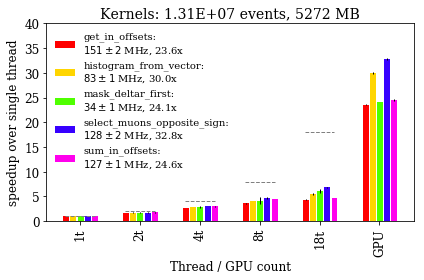

In [38]:
plt.figure(figsize=(6,4))
plt.set_cmap('CMRmap')

marker = itertools.cycle(('o', '.', '^', 's', 'd', 'D')) 
xs = np.arange(len(ms.index.levels[1])+1)
n = -0.23

i = 0
ncores = list(ms.index.levels[1])

for icol, col in enumerate(sorted(ms.columns)):
    if col in ["memory_transfer"]:
        continue
    if col in ["max_in_offsets"]:
        continue
    norm = ms[col].values[0]
    ratio = ms[col].values[-1] / ms[col].values[0]

    m = next(marker)
    color = plt.cm.hsv(icol / len(ms.columns))
    plt.bar(xs + n, ms[col].values/norm, width=0.1, label=col + ":\n${0:.0f} \pm {1:.0f}$ MHz, {2:.1f}x".format(ms[col].values[0], es[col].values[0], ratio), color=color)
    plt.errorbar(xs + n, ms[col].values/norm, es[col].values/norm, lw=0, elinewidth=1, ms=0, color="black")
    plt.plot([i-0.25, i+0.25], [ncores[i], ncores[i]], color="gray", lw=1, ls="--")
    n += 0.12
    
    i += 1
    
plt.legend(frameon=False, fontsize=10, ncol=1, loc=2)
#plt.yscale("log")
plt.ylim(0,40)
#plt.axhline(1, color="black", lw=1)
plt.xticks(xs, ["{0}t".format(x)for x in ms.index.levels[1]] + ["GPU"], fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel("Thread / GPU count", fontsize=12)
plt.ylabel("speedup over single thread", fontsize=12)
plt.title("Kernels: {0:.2E} events, {1:.0f} MB".format(13057075, 5271.84), fontsize=14)
plt.tight_layout()
plt.savefig("/Users/joosep/Dropbox/caltech/hepaccelerate/kernel_benchmarks.pdf", bbox_inches="tight")
plt.savefig("/Users/joosep/Dropbox/caltech/hepaccelerate/kernel_benchmarks.png", bbox_inches="tight")

In [9]:
df.groupby(["use_cuda", "num_threads"])["memory_transfer"].mean()

use_cuda  num_threads
False     1                  2.858922
          2                  4.733589
          4                  9.367935
          8                 13.150172
          18                14.531147
True      1              10432.958076
Name: memory_transfer, dtype: float64

# Full analysis benchmarks

In [10]:
ss = """
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda0_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 779.6995241641998, "evspeed": 0.20561121179578748}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda0_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 788.0082447528839, "evspeed": 0.20344325718352618}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda0_ch4_iter2", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter2/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 776.8831968307495, "evspeed": 0.20635658571841392}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda0_ch4_iter3", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda0_ch4_iter3/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 773.4898571968079, "evspeed": 0.20726188263281808}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda1_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 344.7552936077118, "evspeed": 0.4650108844519101}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda1_ch4_iter2", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter2/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 350.13796281814575, "evspeed": 0.4578622743722999}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt1_cuda1_ch4_iter3", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ggh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/vbf_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/data_2018_14.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/data_2018_81.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_2018_16.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_2018_27.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttw_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttw_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttz_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ttz_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/zz_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wmh_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/wph_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/tth_2018_0.json", "out_nosyst_nt1_cuda1_ch4_iter3/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 333.63750433921814, "evspeed": 0.480506423633368}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt4_cuda0_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/data_2018_14.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/data_2018_81.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_2018_16.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_2018_27.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/zz_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/wph_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/tth_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 360.3915605545044, "evspeed": 0.44483551100180246}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt4_cuda0_ch4_iter2", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ggh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/vbf_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/data_2018_14.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/data_2018_81.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_2018_16.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_2018_27.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttw_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttw_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttz_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ttz_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/zz_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wmh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/wph_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/tth_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter2/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 352.2879011631012, "evspeed": 0.4550680380186484}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nosyst_nt4_cuda0_ch4_iter3", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": false, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ggh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/vbf_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/data_2018_14.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/data_2018_81.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_2018_16.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_2018_27.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_0j_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_0j_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_1j_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_1j_2018_6.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_2j_2018_13.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_2j_2018_9.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_4.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_8.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_11.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_10.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttw_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttw_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttz_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ttz_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_t_top_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_t_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_1.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_2.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/zz_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wmh_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/wph_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/tth_2018_0.json", "out_nosyst_nt4_cuda0_ch4_iter3/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 359.73726630210876, "evspeed": 0.4456445829144842}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt1_cuda0_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt1_cuda0_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/data_2018_14.json", "out_nt1_cuda0_ch4_iter1/jobfiles/data_2018_81.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_16.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_2018_27.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nt1_cuda0_ch4_iter1/jobfiles/zz_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/wph_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/tth_2018_0.json", "out_nt1_cuda0_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 11385.504595041275, "evspeed": 0.014080620025380512}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt1_cuda1_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt1_cuda1_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/data_2018_14.json", "out_nt1_cuda1_ch4_iter1/jobfiles/data_2018_81.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_2018_16.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_2018_27.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nt1_cuda1_ch4_iter1/jobfiles/zz_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/wph_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/tth_2018_0.json", "out_nt1_cuda1_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 2687.568929195404, "evspeed": 0.05965054970627102}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt1_cuda1_ch4_iter2", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt1_cuda1_ch4_iter2/jobfiles/ggh_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/vbf_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/data_2018_14.json", "out_nt1_cuda1_ch4_iter2/jobfiles/data_2018_81.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_2018_16.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_2018_27.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_0j_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_0j_2018_8.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_1j_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_1j_2018_6.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_2j_2018_13.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_2j_2018_9.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttjets_dl_2018_11.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttjets_dl_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttjets_sl_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttjets_sl_2018_10.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttw_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttw_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttz_2018_3.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ttz_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ww_2l2nu_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/ww_2l2nu_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wz_3lnu_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wz_3lnu_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wz_2l2q_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wz_2l2q_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_t_top_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_t_top_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_t_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_t_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_tw_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_tw_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_tw_top_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/st_tw_top_2018_2.json", "out_nt1_cuda1_ch4_iter2/jobfiles/zz_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wmh_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/wph_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/tth_2018_0.json", "out_nt1_cuda1_ch4_iter2/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 2599.1170666217804, "evspeed": 0.061680547620877435}
{"async_data": true, "action": ["analyze"], "nthreads": 1, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt1_cuda1_ch4_iter3", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt1_cuda1_ch4_iter3/jobfiles/ggh_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/vbf_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/data_2018_14.json", "out_nt1_cuda1_ch4_iter3/jobfiles/data_2018_81.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_2018_16.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_2018_27.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_0j_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_0j_2018_8.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_1j_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_1j_2018_6.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_2j_2018_13.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_2j_2018_9.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttjets_dl_2018_11.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttjets_dl_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttjets_sl_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttjets_sl_2018_10.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttw_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttw_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttz_2018_3.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ttz_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ww_2l2nu_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/ww_2l2nu_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wz_3lnu_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wz_3lnu_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wz_2l2q_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wz_2l2q_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_t_top_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_t_top_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_t_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_t_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_tw_antitop_2018_1.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_tw_antitop_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_tw_top_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/st_tw_top_2018_2.json", "out_nt1_cuda1_ch4_iter3/jobfiles/zz_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wmh_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/wph_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/tth_2018_0.json", "out_nt1_cuda1_ch4_iter3/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": true, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 2683.5952417850494, "evspeed": 0.05973887622984573}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt4_cuda0_ch4_iter1", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt4_cuda0_ch4_iter1/jobfiles/ggh_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/vbf_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/data_2018_14.json", "out_nt4_cuda0_ch4_iter1/jobfiles/data_2018_81.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_2018_16.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_2018_27.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_0j_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_0j_2018_8.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_1j_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_1j_2018_6.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_2j_2018_13.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_2j_2018_9.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_11.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttjets_dl_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttjets_sl_2018_10.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttw_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttw_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttz_2018_3.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ttz_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/ww_2l2nu_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wz_3lnu_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wz_2l2q_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_t_top_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_t_top_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_t_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_tw_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/st_tw_top_2018_2.json", "out_nt4_cuda0_ch4_iter1/jobfiles/zz_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wmh_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/wph_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/tth_2018_0.json", "out_nt4_cuda0_ch4_iter1/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 5333.36750793457, "evspeed": 0.030058863140688473}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt4_cuda0_ch4_iter2", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt4_cuda0_ch4_iter2/jobfiles/ggh_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/vbf_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/data_2018_14.json", "out_nt4_cuda0_ch4_iter2/jobfiles/data_2018_81.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_2018_16.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_2018_27.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_0j_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_0j_2018_8.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_1j_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_1j_2018_6.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_2j_2018_13.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_2j_2018_9.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_11.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttjets_dl_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttjets_sl_2018_10.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttw_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttw_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttz_2018_3.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ttz_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/ww_2l2nu_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wz_3lnu_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wz_2l2q_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_t_top_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_t_top_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_t_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_tw_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/st_tw_top_2018_2.json", "out_nt4_cuda0_ch4_iter2/jobfiles/zz_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wmh_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/wph_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/tth_2018_0.json", "out_nt4_cuda0_ch4_iter2/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 5169.173804998398, "evspeed": 0.0310136532544101}
{"async_data": true, "action": ["analyze"], "nthreads": 4, "datapath": "/storage/user/jpata/", "maxchunks": 2, "chunksize": 4, "cache_location": "/nvme1/jpata/cache", "out": "out_nt4_cuda0_ch4_iter3", "datasets": null, "eras": ["2018"], "pinned": true, "do_sync": false, "do_factorized_jec": true, "do_profile": false, "disable_tensorflow": false, "jobfiles": ["out_nt4_cuda0_ch4_iter3/jobfiles/ggh_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/vbf_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/data_2018_14.json", "out_nt4_cuda0_ch4_iter3/jobfiles/data_2018_81.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_2018_16.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_2018_27.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_0j_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_0j_2018_8.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_1j_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_1j_2018_6.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_2j_2018_13.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_2j_2018_9.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_4.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_amc_2018_8.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_amc_2018_7.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_3.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_mg_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/dy_m105_160_vbf_mg_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_11.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttjets_dl_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttjets_sl_2018_10.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttw_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttw_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttz_2018_3.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ttz_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll50_mjj120_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_3.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ewk_lljj_mll105_160_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/ww_2l2nu_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wz_3lnu_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wz_2l2q_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_t_top_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_t_top_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_t_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_1.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_tw_antitop_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/st_tw_top_2018_2.json", "out_nt4_cuda0_ch4_iter3/jobfiles/zz_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wmh_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/wph_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/tth_2018_0.json", "out_nt4_cuda0_ch4_iter3/jobfiles/zh_2018_0.json"], "jobfiles_load": null, "use_cuda": false, "hostname": "mawhrin-skel-sm.hep.caltech.edu", "nev_total": 160314964, "total_time": 5144.791873455048, "evspeed": 0.031160631555798683}
"""

In [11]:
dd = []
for line in ss.split("\n"):
    if len(line) > 0:
        d = json.loads(line)
        dd += [d]
df = pandas.DataFrame(dd)
df["evspeed"] = df["evspeed"]*1000

In [12]:
df["syst_type"] = "full"
df.loc[df["do_factorized_jec"]==False, "syst_type"] = "partial"

In [13]:
df["proc_mode"] = "1c"
df.loc[df["nthreads"]==4, "proc_mode"] = "4c"
df.loc[df["use_cuda"]==1, "proc_mode"] = "g"

dfg_full = df.query("syst_type=='full'").groupby(["proc_mode"])
dfg_partial = df.query("syst_type=='partial'").groupby(["proc_mode"])

In [14]:
ms1 = dfg_full["evspeed"].mean()
es1 = dfg_full["evspeed"].std()

ms2 = dfg_partial["evspeed"].mean()
es2 = dfg_partial["evspeed"].std()

In [15]:
ms1[::-1]

proc_mode
g     60.356658
4c    30.744383
1c    14.080620
Name: evspeed, dtype: float64

In [16]:
ms2[::-1]

proc_mode
g     467.793194
4c    448.516044
1c    205.668234
Name: evspeed, dtype: float64

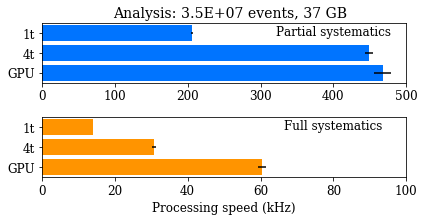

In [78]:
plt.figure(figsize=(6, 3))
plt.set_cmap('CMRmap')

plt.subplot(2,1,1)
plt.title("Partial systematics", fontsize=12, y=0.7, x=0.8)

width = 1
xs = width*np.array(range(len(ms2.values)))

color = plt.cm.hsv(0.6)  
plt.barh(xs, ms2.values[::-1], xerr=es2.values[::-1], height=width*0.8, orientation="horizontal", color=color)
# for i in range(len(ms2.values)):
#     plt.text(ms2.values[::-1][i]+10, i, "${0:.1f} \pm {1:.1f}$".format(ms2.values[::-1][i], es2.values[::-1][i]), fontsize=12)
plt.yticks(xs, ["1t", "4t", "GPU"][::-1], fontsize=12)
plt.xticks(fontsize=12)
#plt.xlabel("Processing speed (kHz)", fontsize=16)
plt.xlim(0,500)
plt.ylim(min(xs)-width*0.5, max(xs)+width*0.5)

plt.subplot(2,1,2)
color = plt.cm.hsv(0.1)  
plt.title("Full systematics", fontsize=12, y=0.7, x=0.8)
plt.barh(xs, ms1.values[::-1], xerr=es1.values[::-1], height=width*0.8, orientation="horizontal", color=color)
# for i in range(len(ms1.values)):
#     plt.text(ms1.values[::-1][i]+10, i, "${0:.1f} \pm {1:.1f}$".format(ms1.values[::-1][i], es1.values[::-1][i]), fontsize=12)
plt.yticks(xs, ["1t", "4t", "GPU"][::-1], fontsize=12)
plt.xticks(fontsize=12)
plt.xlabel("Processing speed (kHz)", fontsize=12)
plt.xlim(0,100)
plt.ylim(min(xs)-width*0.5, max(xs)+width*0.5)

plt.tight_layout()
plt.suptitle("Analysis: {0:.1E} events, {1:.0f} GB".format(3.47E+07, 37.16), fontsize=14, y=1.01, x=0.54)
plt.savefig("/Users/joosep/Dropbox/caltech/hepaccelerate/analysis_benchmark.pdf", bbox_inches="tight")
plt.savefig("/Users/joosep/Dropbox/caltech/hepaccelerate/analysis_benchmark.png", bbox_inches="tight")

# Job benchmarks

In [18]:
s = """
logs/example_job.out.2011312.0:In run_analysis, processed 6.53E+06 (2.98E+07 raw NanoAOD equivalent) events in total 4.69 GB, 3330.1 seconds, 8.95E+03 Hz, 1.44 MB/s
logs/example_job.out.2011312.1:In run_analysis, processed 5.23E+06 (2.97E+07 raw NanoAOD equivalent) events in total 3.33 GB, 3198.2 seconds, 9.28E+03 Hz, 1.07 MB/s
logs/example_job.out.2011312.10:In run_analysis, processed 4.19E+06 (2.80E+07 raw NanoAOD equivalent) events in total 3.06 GB, 2947.5 seconds, 9.51E+03 Hz, 1.06 MB/s
logs/example_job.out.2011312.100:In run_analysis, processed 3.86E+06 (2.14E+07 raw NanoAOD equivalent) events in total 3.56 GB, 4967.9 seconds, 4.31E+03 Hz, 0.73 MB/s
logs/example_job.out.2011312.101:In run_analysis, processed 4.06E+06 (2.49E+07 raw NanoAOD equivalent) events in total 3.17 GB, 2496.7 seconds, 9.98E+03 Hz, 1.30 MB/s
logs/example_job.out.2011312.102:In run_analysis, processed 4.30E+06 (2.09E+07 raw NanoAOD equivalent) events in total 3.83 GB, 3905.7 seconds, 5.36E+03 Hz, 1.01 MB/s
logs/example_job.out.2011312.103:In run_analysis, processed 3.36E+06 (2.56E+07 raw NanoAOD equivalent) events in total 2.92 GB, 2597.4 seconds, 9.84E+03 Hz, 1.15 MB/s
logs/example_job.out.2011312.104:In run_analysis, processed 4.06E+06 (2.17E+07 raw NanoAOD equivalent) events in total 3.47 GB, 4883.1 seconds, 4.44E+03 Hz, 0.73 MB/s
logs/example_job.out.2011312.105:In run_analysis, processed 4.81E+06 (2.92E+07 raw NanoAOD equivalent) events in total 4.00 GB, 2451.8 seconds, 1.19E+04 Hz, 1.67 MB/s
logs/example_job.out.2011312.106:In run_analysis, processed 3.50E+06 (2.30E+07 raw NanoAOD equivalent) events in total 2.44 GB, 1780.6 seconds, 1.29E+04 Hz, 1.40 MB/s
logs/example_job.out.2011312.107:In run_analysis, processed 4.13E+06 (2.18E+07 raw NanoAOD equivalent) events in total 3.85 GB, 3242.1 seconds, 6.73E+03 Hz, 1.22 MB/s
logs/example_job.out.2011312.108:In run_analysis, processed 4.90E+06 (2.72E+07 raw NanoAOD equivalent) events in total 3.80 GB, 3392.3 seconds, 8.02E+03 Hz, 1.15 MB/s
logs/example_job.out.2011312.109:In run_analysis, processed 5.12E+06 (3.12E+07 raw NanoAOD equivalent) events in total 3.51 GB, 2631.0 seconds, 1.18E+04 Hz, 1.37 MB/s
logs/example_job.out.2011312.11:In run_analysis, processed 4.53E+06 (2.95E+07 raw NanoAOD equivalent) events in total 3.19 GB, 2402.8 seconds, 1.23E+04 Hz, 1.36 MB/s
logs/example_job.out.2011312.110:In run_analysis, processed 3.26E+06 (2.09E+07 raw NanoAOD equivalent) events in total 3.07 GB, 2537.9 seconds, 8.23E+03 Hz, 1.24 MB/s
logs/example_job.out.2011312.111:In run_analysis, processed 4.05E+06 (2.79E+07 raw NanoAOD equivalent) events in total 3.13 GB, 1831.3 seconds, 1.53E+04 Hz, 1.75 MB/s
logs/example_job.out.2011312.112:In run_analysis, processed 4.28E+06 (2.22E+07 raw NanoAOD equivalent) events in total 3.16 GB, 1851.9 seconds, 1.20E+04 Hz, 1.75 MB/s
logs/example_job.out.2011312.113:In run_analysis, processed 3.21E+06 (2.04E+07 raw NanoAOD equivalent) events in total 3.10 GB, 3868.5 seconds, 5.26E+03 Hz, 0.82 MB/s
logs/example_job.out.2011312.114:In run_analysis, processed 4.96E+06 (2.89E+07 raw NanoAOD equivalent) events in total 4.37 GB, 4203.4 seconds, 6.89E+03 Hz, 1.07 MB/s
logs/example_job.out.2011312.115:In run_analysis, processed 4.84E+06 (2.45E+07 raw NanoAOD equivalent) events in total 4.27 GB, 3977.6 seconds, 6.16E+03 Hz, 1.10 MB/s
logs/example_job.out.2011312.116:In run_analysis, processed 4.47E+06 (2.14E+07 raw NanoAOD equivalent) events in total 3.45 GB, 4321.5 seconds, 4.96E+03 Hz, 0.82 MB/s
logs/example_job.out.2011312.117:In run_analysis, processed 4.83E+06 (2.92E+07 raw NanoAOD equivalent) events in total 3.80 GB, 2193.0 seconds, 1.33E+04 Hz, 1.78 MB/s
logs/example_job.out.2011312.118:In run_analysis, processed 4.58E+06 (2.12E+07 raw NanoAOD equivalent) events in total 3.90 GB, 5198.3 seconds, 4.09E+03 Hz, 0.77 MB/s
logs/example_job.out.2011312.119:In run_analysis, processed 5.09E+06 (2.73E+07 raw NanoAOD equivalent) events in total 4.43 GB, 3600.2 seconds, 7.57E+03 Hz, 1.26 MB/s
logs/example_job.out.2011312.12:In run_analysis, processed 3.46E+06 (2.22E+07 raw NanoAOD equivalent) events in total 3.16 GB, 3639.0 seconds, 6.09E+03 Hz, 0.89 MB/s
logs/example_job.out.2011312.120:In run_analysis, processed 3.60E+06 (2.42E+07 raw NanoAOD equivalent) events in total 3.62 GB, 3877.8 seconds, 6.25E+03 Hz, 0.95 MB/s
logs/example_job.out.2011312.121:In run_analysis, processed 4.83E+06 (2.44E+07 raw NanoAOD equivalent) events in total 3.62 GB, 2978.0 seconds, 8.21E+03 Hz, 1.25 MB/s
logs/example_job.out.2011312.122:In run_analysis, processed 3.90E+06 (2.37E+07 raw NanoAOD equivalent) events in total 2.97 GB, 3057.8 seconds, 7.77E+03 Hz, 0.99 MB/s
logs/example_job.out.2011312.123:In run_analysis, processed 5.26E+06 (2.79E+07 raw NanoAOD equivalent) events in total 4.32 GB, 4372.9 seconds, 6.37E+03 Hz, 1.01 MB/s
logs/example_job.out.2011312.124:In run_analysis, processed 4.19E+06 (2.26E+07 raw NanoAOD equivalent) events in total 3.27 GB, 2208.4 seconds, 1.02E+04 Hz, 1.52 MB/s
logs/example_job.out.2011312.125:In run_analysis, processed 4.89E+06 (2.33E+07 raw NanoAOD equivalent) events in total 3.66 GB, 2991.1 seconds, 7.79E+03 Hz, 1.25 MB/s
logs/example_job.out.2011312.126:In run_analysis, processed 3.24E+06 (1.87E+07 raw NanoAOD equivalent) events in total 2.83 GB, 2751.4 seconds, 6.81E+03 Hz, 1.05 MB/s
logs/example_job.out.2011312.127:In run_analysis, processed 5.82E+06 (3.14E+07 raw NanoAOD equivalent) events in total 4.40 GB, 3016.4 seconds, 1.04E+04 Hz, 1.49 MB/s
logs/example_job.out.2011312.128:In run_analysis, processed 4.29E+06 (2.85E+07 raw NanoAOD equivalent) events in total 2.86 GB, 2994.9 seconds, 9.51E+03 Hz, 0.98 MB/s
logs/example_job.out.2011312.129:In run_analysis, processed 4.90E+06 (2.08E+07 raw NanoAOD equivalent) events in total 3.90 GB, 2878.1 seconds, 7.24E+03 Hz, 1.39 MB/s
logs/example_job.out.2011312.13:In run_analysis, processed 6.22E+06 (2.77E+07 raw NanoAOD equivalent) events in total 5.21 GB, 4090.0 seconds, 6.77E+03 Hz, 1.30 MB/s
logs/example_job.out.2011312.130:In run_analysis, processed 5.12E+06 (3.10E+07 raw NanoAOD equivalent) events in total 3.27 GB, 1892.9 seconds, 1.64E+04 Hz, 1.77 MB/s
logs/example_job.out.2011312.131:In run_analysis, processed 3.78E+06 (2.60E+07 raw NanoAOD equivalent) events in total 2.51 GB, 1603.9 seconds, 1.62E+04 Hz, 1.60 MB/s
logs/example_job.out.2011312.132:In run_analysis, processed 3.76E+06 (2.10E+07 raw NanoAOD equivalent) events in total 2.71 GB, 2731.2 seconds, 7.68E+03 Hz, 1.02 MB/s
logs/example_job.out.2011312.133:In run_analysis, processed 5.29E+06 (2.84E+07 raw NanoAOD equivalent) events in total 4.14 GB, 2445.6 seconds, 1.16E+04 Hz, 1.73 MB/s
logs/example_job.out.2011312.134:In run_analysis, processed 3.70E+06 (2.35E+07 raw NanoAOD equivalent) events in total 2.89 GB, 3340.2 seconds, 7.04E+03 Hz, 0.89 MB/s
logs/example_job.out.2011312.135:In run_analysis, processed 4.37E+06 (2.32E+07 raw NanoAOD equivalent) events in total 3.12 GB, 1576.4 seconds, 1.47E+04 Hz, 2.03 MB/s
logs/example_job.out.2011312.136:In run_analysis, processed 5.46E+06 (2.74E+07 raw NanoAOD equivalent) events in total 4.05 GB, 3006.2 seconds, 9.12E+03 Hz, 1.38 MB/s
logs/example_job.out.2011312.137:In run_analysis, processed 4.70E+06 (3.11E+07 raw NanoAOD equivalent) events in total 3.45 GB, 3344.3 seconds, 9.30E+03 Hz, 1.06 MB/s
logs/example_job.out.2011312.138:In run_analysis, processed 4.06E+06 (2.40E+07 raw NanoAOD equivalent) events in total 3.53 GB, 3188.4 seconds, 7.54E+03 Hz, 1.13 MB/s
logs/example_job.out.2011312.139:In run_analysis, processed 5.13E+06 (2.78E+07 raw NanoAOD equivalent) events in total 4.24 GB, 3580.4 seconds, 7.75E+03 Hz, 1.21 MB/s
logs/example_job.out.2011312.14:In run_analysis, processed 4.44E+06 (2.60E+07 raw NanoAOD equivalent) events in total 3.29 GB, 6188.1 seconds, 4.20E+03 Hz, 0.54 MB/s
logs/example_job.out.2011312.140:In run_analysis, processed 4.74E+06 (2.39E+07 raw NanoAOD equivalent) events in total 4.07 GB, 3836.7 seconds, 6.24E+03 Hz, 1.09 MB/s
logs/example_job.out.2011312.141:In run_analysis, processed 4.25E+06 (2.52E+07 raw NanoAOD equivalent) events in total 2.80 GB, 1907.9 seconds, 1.32E+04 Hz, 1.50 MB/s
logs/example_job.out.2011312.142:In run_analysis, processed 5.39E+06 (3.02E+07 raw NanoAOD equivalent) events in total 4.36 GB, 2992.6 seconds, 1.01E+04 Hz, 1.49 MB/s
logs/example_job.out.2011312.143:In run_analysis, processed 5.18E+06 (2.63E+07 raw NanoAOD equivalent) events in total 4.29 GB, 3446.6 seconds, 7.64E+03 Hz, 1.27 MB/s
logs/example_job.out.2011312.144:In run_analysis, processed 3.67E+06 (2.23E+07 raw NanoAOD equivalent) events in total 3.49 GB, 3999.2 seconds, 5.58E+03 Hz, 0.89 MB/s
logs/example_job.out.2011312.145:In run_analysis, processed 3.81E+06 (2.33E+07 raw NanoAOD equivalent) events in total 2.87 GB, 2849.5 seconds, 8.17E+03 Hz, 1.03 MB/s
logs/example_job.out.2011312.146:In run_analysis, processed 4.07E+06 (2.01E+07 raw NanoAOD equivalent) events in total 3.46 GB, 2223.7 seconds, 9.04E+03 Hz, 1.59 MB/s
logs/example_job.out.2011312.147:In run_analysis, processed 5.19E+06 (2.33E+07 raw NanoAOD equivalent) events in total 4.68 GB, 4297.1 seconds, 5.42E+03 Hz, 1.11 MB/s
logs/example_job.out.2011312.148:In run_analysis, processed 4.19E+06 (2.29E+07 raw NanoAOD equivalent) events in total 4.71 GB, 4932.7 seconds, 4.64E+03 Hz, 0.98 MB/s
logs/example_job.out.2011312.149:In run_analysis, processed 4.37E+06 (2.55E+07 raw NanoAOD equivalent) events in total 3.93 GB, 3341.5 seconds, 7.65E+03 Hz, 1.21 MB/s
logs/example_job.out.2011312.15:In run_analysis, processed 4.02E+06 (2.46E+07 raw NanoAOD equivalent) events in total 3.12 GB, 2504.4 seconds, 9.82E+03 Hz, 1.28 MB/s
logs/example_job.out.2011312.150:In run_analysis, processed 4.02E+06 (2.85E+07 raw NanoAOD equivalent) events in total 3.11 GB, 2251.9 seconds, 1.27E+04 Hz, 1.42 MB/s
logs/example_job.out.2011312.151:In run_analysis, processed 5.57E+06 (3.15E+07 raw NanoAOD equivalent) events in total 3.47 GB, 2886.6 seconds, 1.09E+04 Hz, 1.23 MB/s
logs/example_job.out.2011312.152:In run_analysis, processed 3.13E+06 (2.03E+07 raw NanoAOD equivalent) events in total 2.45 GB, 1449.0 seconds, 1.40E+04 Hz, 1.73 MB/s
logs/example_job.out.2011312.153:In run_analysis, processed 4.46E+06 (2.95E+07 raw NanoAOD equivalent) events in total 3.08 GB, 2837.0 seconds, 1.04E+04 Hz, 1.11 MB/s
logs/example_job.out.2011312.154:In run_analysis, processed 4.30E+06 (2.37E+07 raw NanoAOD equivalent) events in total 3.60 GB, 3455.8 seconds, 6.87E+03 Hz, 1.07 MB/s
logs/example_job.out.2011312.155:In run_analysis, processed 4.12E+06 (2.83E+07 raw NanoAOD equivalent) events in total 2.49 GB, 2064.4 seconds, 1.37E+04 Hz, 1.24 MB/s
logs/example_job.out.2011312.156:In run_analysis, processed 5.60E+06 (3.19E+07 raw NanoAOD equivalent) events in total 3.60 GB, 1600.6 seconds, 1.99E+04 Hz, 2.30 MB/s
logs/example_job.out.2011312.157:In run_analysis, processed 4.62E+06 (2.29E+07 raw NanoAOD equivalent) events in total 3.71 GB, 3587.6 seconds, 6.39E+03 Hz, 1.06 MB/s
logs/example_job.out.2011312.158:In run_analysis, processed 4.08E+06 (2.57E+07 raw NanoAOD equivalent) events in total 3.14 GB, 2082.9 seconds, 1.24E+04 Hz, 1.54 MB/s
logs/example_job.out.2011312.159:In run_analysis, processed 5.98E+06 (2.76E+07 raw NanoAOD equivalent) events in total 4.66 GB, 5470.8 seconds, 5.05E+03 Hz, 0.87 MB/s
logs/example_job.out.2011312.16:In run_analysis, processed 3.91E+06 (2.61E+07 raw NanoAOD equivalent) events in total 3.15 GB, 1715.6 seconds, 1.52E+04 Hz, 1.88 MB/s
logs/example_job.out.2011312.160:In run_analysis, processed 4.70E+06 (2.71E+07 raw NanoAOD equivalent) events in total 3.91 GB, 2733.5 seconds, 9.93E+03 Hz, 1.46 MB/s
logs/example_job.out.2011312.161:In run_analysis, processed 3.88E+06 (2.81E+07 raw NanoAOD equivalent) events in total 3.13 GB, 2798.9 seconds, 1.01E+04 Hz, 1.15 MB/s
logs/example_job.out.2011312.162:In run_analysis, processed 4.45E+06 (2.71E+07 raw NanoAOD equivalent) events in total 3.76 GB, 2849.2 seconds, 9.52E+03 Hz, 1.35 MB/s
logs/example_job.out.2011312.163:In run_analysis, processed 5.67E+06 (2.63E+07 raw NanoAOD equivalent) events in total 4.73 GB, 3818.2 seconds, 6.89E+03 Hz, 1.27 MB/s
logs/example_job.out.2011312.164:In run_analysis, processed 5.40E+06 (2.74E+07 raw NanoAOD equivalent) events in total 3.98 GB, 2875.8 seconds, 9.53E+03 Hz, 1.42 MB/s
logs/example_job.out.2011312.165:In run_analysis, processed 5.40E+06 (3.06E+07 raw NanoAOD equivalent) events in total 3.72 GB, 2536.4 seconds, 1.21E+04 Hz, 1.50 MB/s
logs/example_job.out.2011312.166:In run_analysis, processed 3.52E+06 (1.80E+07 raw NanoAOD equivalent) events in total 3.67 GB, 3919.4 seconds, 4.59E+03 Hz, 0.96 MB/s
logs/example_job.out.2011312.167:In run_analysis, processed 4.94E+06 (2.34E+07 raw NanoAOD equivalent) events in total 3.82 GB, 3644.2 seconds, 6.43E+03 Hz, 1.07 MB/s
logs/example_job.out.2011312.168:In run_analysis, processed 4.97E+06 (2.44E+07 raw NanoAOD equivalent) events in total 4.34 GB, 3628.5 seconds, 6.73E+03 Hz, 1.22 MB/s
logs/example_job.out.2011312.169:In run_analysis, processed 2.86E+06 (1.99E+07 raw NanoAOD equivalent) events in total 2.51 GB, 2393.2 seconds, 8.33E+03 Hz, 1.07 MB/s
logs/example_job.out.2011312.17:In run_analysis, processed 4.71E+06 (2.64E+07 raw NanoAOD equivalent) events in total 3.10 GB, 1651.1 seconds, 1.60E+04 Hz, 1.92 MB/s
logs/example_job.out.2011312.170:In run_analysis, processed 4.39E+06 (2.81E+07 raw NanoAOD equivalent) events in total 3.80 GB, 2632.1 seconds, 1.07E+04 Hz, 1.48 MB/s
logs/example_job.out.2011312.171:In run_analysis, processed 4.15E+06 (2.27E+07 raw NanoAOD equivalent) events in total 3.16 GB, 4400.1 seconds, 5.16E+03 Hz, 0.74 MB/s
logs/example_job.out.2011312.172:In run_analysis, processed 5.14E+06 (2.34E+07 raw NanoAOD equivalent) events in total 4.45 GB, 4491.8 seconds, 5.22E+03 Hz, 1.01 MB/s
logs/example_job.out.2011312.173:In run_analysis, processed 4.62E+06 (2.96E+07 raw NanoAOD equivalent) events in total 4.05 GB, 3931.6 seconds, 7.52E+03 Hz, 1.05 MB/s
logs/example_job.out.2011312.174:In run_analysis, processed 4.15E+06 (2.81E+07 raw NanoAOD equivalent) events in total 2.50 GB, 1405.9 seconds, 2.00E+04 Hz, 1.82 MB/s
logs/example_job.out.2011312.175:In run_analysis, processed 3.18E+06 (2.17E+07 raw NanoAOD equivalent) events in total 3.30 GB, 2731.9 seconds, 7.95E+03 Hz, 1.24 MB/s
logs/example_job.out.2011312.176:In run_analysis, processed 5.29E+06 (2.58E+07 raw NanoAOD equivalent) events in total 4.53 GB, 3724.0 seconds, 6.93E+03 Hz, 1.24 MB/s
logs/example_job.out.2011312.177:In run_analysis, processed 4.84E+06 (2.54E+07 raw NanoAOD equivalent) events in total 3.73 GB, 2543.0 seconds, 9.98E+03 Hz, 1.50 MB/s
logs/example_job.out.2011312.178:In run_analysis, processed 4.84E+06 (1.97E+07 raw NanoAOD equivalent) events in total 4.43 GB, 3639.1 seconds, 5.41E+03 Hz, 1.25 MB/s
logs/example_job.out.2011312.179:In run_analysis, processed 4.03E+06 (1.87E+07 raw NanoAOD equivalent) events in total 3.62 GB, 2790.0 seconds, 6.71E+03 Hz, 1.33 MB/s
logs/example_job.out.2011312.18:In run_analysis, processed 4.70E+06 (2.75E+07 raw NanoAOD equivalent) events in total 3.37 GB, 5871.7 seconds, 4.68E+03 Hz, 0.59 MB/s
logs/example_job.out.2011312.180:In run_analysis, processed 4.81E+06 (3.11E+07 raw NanoAOD equivalent) events in total 3.53 GB, 2782.8 seconds, 1.12E+04 Hz, 1.30 MB/s
logs/example_job.out.2011312.181:In run_analysis, processed 4.28E+06 (2.50E+07 raw NanoAOD equivalent) events in total 3.68 GB, 4255.4 seconds, 5.88E+03 Hz, 0.89 MB/s
logs/example_job.out.2011312.182:In run_analysis, processed 5.08E+06 (2.96E+07 raw NanoAOD equivalent) events in total 4.32 GB, 3315.6 seconds, 8.92E+03 Hz, 1.34 MB/s
logs/example_job.out.2011312.183:In run_analysis, processed 2.77E+06 (2.05E+07 raw NanoAOD equivalent) events in total 2.25 GB, 1675.5 seconds, 1.22E+04 Hz, 1.38 MB/s
logs/example_job.out.2011312.184:In run_analysis, processed 5.21E+06 (1.90E+07 raw NanoAOD equivalent) events in total 4.84 GB, 4724.2 seconds, 4.03E+03 Hz, 1.05 MB/s
logs/example_job.out.2011312.185:In run_analysis, processed 5.54E+06 (2.61E+07 raw NanoAOD equivalent) events in total 4.91 GB, 4138.2 seconds, 6.32E+03 Hz, 1.22 MB/s
logs/example_job.out.2011312.186:In run_analysis, processed 4.78E+06 (2.59E+07 raw NanoAOD equivalent) events in total 4.03 GB, 3812.8 seconds, 6.80E+03 Hz, 1.08 MB/s
logs/example_job.out.2011312.187:In run_analysis, processed 4.12E+06 (2.71E+07 raw NanoAOD equivalent) events in total 2.45 GB, 1583.5 seconds, 1.71E+04 Hz, 1.58 MB/s
logs/example_job.out.2011312.188:In run_analysis, processed 4.37E+06 (2.59E+07 raw NanoAOD equivalent) events in total 3.56 GB, 4359.7 seconds, 5.93E+03 Hz, 0.84 MB/s
logs/example_job.out.2011312.189:In run_analysis, processed 3.07E+06 (1.74E+07 raw NanoAOD equivalent) events in total 3.07 GB, 4744.1 seconds, 3.66E+03 Hz, 0.66 MB/s
logs/example_job.out.2011312.19:In run_analysis, processed 4.99E+06 (2.94E+07 raw NanoAOD equivalent) events in total 3.90 GB, 2474.4 seconds, 1.19E+04 Hz, 1.61 MB/s
logs/example_job.out.2011312.190:In run_analysis, processed 4.70E+06 (2.64E+07 raw NanoAOD equivalent) events in total 3.28 GB, 4482.1 seconds, 5.88E+03 Hz, 0.75 MB/s
logs/example_job.out.2011312.191:In run_analysis, processed 5.31E+06 (2.52E+07 raw NanoAOD equivalent) events in total 4.26 GB, 3172.9 seconds, 7.95E+03 Hz, 1.37 MB/s
logs/example_job.out.2011312.192:In run_analysis, processed 4.18E+06 (2.17E+07 raw NanoAOD equivalent) events in total 3.34 GB, 3565.9 seconds, 6.09E+03 Hz, 0.96 MB/s
logs/example_job.out.2011312.193:In run_analysis, processed 4.62E+06 (2.37E+07 raw NanoAOD equivalent) events in total 3.72 GB, 2628.8 seconds, 9.00E+03 Hz, 1.45 MB/s
logs/example_job.out.2011312.194:In run_analysis, processed 4.09E+06 (2.89E+07 raw NanoAOD equivalent) events in total 3.14 GB, 1990.0 seconds, 1.45E+04 Hz, 1.61 MB/s
logs/example_job.out.2011312.195:In run_analysis, processed 3.62E+06 (2.17E+07 raw NanoAOD equivalent) events in total 3.55 GB, 3914.2 seconds, 5.54E+03 Hz, 0.93 MB/s
logs/example_job.out.2011312.196:In run_analysis, processed 5.88E+06 (2.71E+07 raw NanoAOD equivalent) events in total 5.07 GB, 4466.6 seconds, 6.06E+03 Hz, 1.16 MB/s
logs/example_job.out.2011312.197:In run_analysis, processed 3.41E+06 (2.47E+07 raw NanoAOD equivalent) events in total 2.87 GB, 2295.8 seconds, 1.07E+04 Hz, 1.28 MB/s
logs/example_job.out.2011312.198:In run_analysis, processed 3.89E+06 (2.77E+07 raw NanoAOD equivalent) events in total 2.92 GB, 2053.1 seconds, 1.35E+04 Hz, 1.46 MB/s
logs/example_job.out.2011312.199:In run_analysis, processed 4.17E+06 (2.62E+07 raw NanoAOD equivalent) events in total 3.16 GB, 2672.1 seconds, 9.79E+03 Hz, 1.21 MB/s
logs/example_job.out.2011312.2:In run_analysis, processed 4.38E+06 (2.90E+07 raw NanoAOD equivalent) events in total 2.90 GB, 1444.6 seconds, 2.01E+04 Hz, 2.06 MB/s
logs/example_job.out.2011312.20:In run_analysis, processed 3.83E+06 (2.78E+07 raw NanoAOD equivalent) events in total 2.32 GB, 1304.7 seconds, 2.13E+04 Hz, 1.82 MB/s
logs/example_job.out.2011312.200:In run_analysis, processed 4.11E+06 (2.30E+07 raw NanoAOD equivalent) events in total 3.00 GB, 2448.7 seconds, 9.40E+03 Hz, 1.26 MB/s
logs/example_job.out.2011312.21:In run_analysis, processed 4.33E+06 (2.53E+07 raw NanoAOD equivalent) events in total 3.17 GB, 2370.3 seconds, 1.07E+04 Hz, 1.37 MB/s
logs/example_job.out.2011312.22:In run_analysis, processed 3.80E+06 (2.20E+07 raw NanoAOD equivalent) events in total 3.96 GB, 8759.5 seconds, 2.51E+03 Hz, 0.46 MB/s
logs/example_job.out.2011312.23:In run_analysis, processed 4.05E+06 (2.37E+07 raw NanoAOD equivalent) events in total 2.92 GB, 2094.2 seconds, 1.13E+04 Hz, 1.43 MB/s
logs/example_job.out.2011312.24:In run_analysis, processed 4.84E+06 (3.08E+07 raw NanoAOD equivalent) events in total 3.02 GB, 1187.8 seconds, 2.59E+04 Hz, 2.61 MB/s
logs/example_job.out.2011312.25:In run_analysis, processed 5.42E+06 (2.79E+07 raw NanoAOD equivalent) events in total 4.03 GB, 3113.5 seconds, 8.96E+03 Hz, 1.33 MB/s
logs/example_job.out.2011312.26:In run_analysis, processed 3.73E+06 (2.36E+07 raw NanoAOD equivalent) events in total 2.58 GB, 4508.0 seconds, 5.24E+03 Hz, 0.59 MB/s
logs/example_job.out.2011312.27:In run_analysis, processed 4.61E+06 (3.21E+07 raw NanoAOD equivalent) events in total 2.96 GB, 1582.7 seconds, 2.03E+04 Hz, 1.91 MB/s
logs/example_job.out.2011312.28:In run_analysis, processed 5.96E+06 (2.55E+07 raw NanoAOD equivalent) events in total 5.11 GB, 4141.9 seconds, 6.15E+03 Hz, 1.26 MB/s
logs/example_job.out.2011312.29:In run_analysis, processed 3.66E+06 (2.60E+07 raw NanoAOD equivalent) events in total 3.11 GB, 3459.1 seconds, 7.51E+03 Hz, 0.92 MB/s
logs/example_job.out.2011312.3:In run_analysis, processed 4.77E+06 (2.03E+07 raw NanoAOD equivalent) events in total 4.35 GB, 4885.3 seconds, 4.16E+03 Hz, 0.91 MB/s
logs/example_job.out.2011312.30:In run_analysis, processed 5.23E+06 (2.06E+07 raw NanoAOD equivalent) events in total 4.46 GB, 6811.3 seconds, 3.02E+03 Hz, 0.67 MB/s
logs/example_job.out.2011312.31:In run_analysis, processed 3.28E+06 (1.91E+07 raw NanoAOD equivalent) events in total 2.30 GB, 2030.1 seconds, 9.43E+03 Hz, 1.16 MB/s
logs/example_job.out.2011312.32:In run_analysis, processed 2.47E+06 (1.94E+07 raw NanoAOD equivalent) events in total 1.91 GB, 1805.6 seconds, 1.08E+04 Hz, 1.08 MB/s
logs/example_job.out.2011312.33:In run_analysis, processed 4.29E+06 (2.61E+07 raw NanoAOD equivalent) events in total 3.21 GB, 2959.7 seconds, 8.83E+03 Hz, 1.11 MB/s
logs/example_job.out.2011312.34:In run_analysis, processed 4.97E+06 (2.67E+07 raw NanoAOD equivalent) events in total 3.56 GB, 2406.4 seconds, 1.11E+04 Hz, 1.51 MB/s
logs/example_job.out.2011312.35:In run_analysis, processed 5.36E+06 (2.94E+07 raw NanoAOD equivalent) events in total 4.09 GB, 2354.5 seconds, 1.25E+04 Hz, 1.78 MB/s
logs/example_job.out.2011312.36:In run_analysis, processed 3.63E+06 (2.61E+07 raw NanoAOD equivalent) events in total 2.27 GB, 1219.5 seconds, 2.14E+04 Hz, 1.90 MB/s
logs/example_job.out.2011312.37:In run_analysis, processed 4.64E+06 (2.55E+07 raw NanoAOD equivalent) events in total 3.38 GB, 2878.1 seconds, 8.85E+03 Hz, 1.20 MB/s
logs/example_job.out.2011312.38:In run_analysis, processed 4.16E+06 (2.20E+07 raw NanoAOD equivalent) events in total 2.96 GB, 3115.2 seconds, 7.06E+03 Hz, 0.97 MB/s
logs/example_job.out.2011312.39:In run_analysis, processed 5.67E+06 (3.06E+07 raw NanoAOD equivalent) events in total 4.35 GB, 3495.8 seconds, 8.76E+03 Hz, 1.27 MB/s
logs/example_job.out.2011312.4:In run_analysis, processed 4.74E+06 (2.83E+07 raw NanoAOD equivalent) events in total 3.42 GB, 2607.2 seconds, 1.08E+04 Hz, 1.34 MB/s
logs/example_job.out.2011312.40:In run_analysis, processed 3.77E+06 (2.55E+07 raw NanoAOD equivalent) events in total 2.81 GB, 2347.3 seconds, 1.09E+04 Hz, 1.23 MB/s
logs/example_job.out.2011312.41:In run_analysis, processed 3.88E+06 (2.59E+07 raw NanoAOD equivalent) events in total 2.70 GB, 2624.6 seconds, 9.86E+03 Hz, 1.05 MB/s
logs/example_job.out.2011312.42:In run_analysis, processed 4.64E+06 (2.54E+07 raw NanoAOD equivalent) events in total 3.40 GB, 6375.2 seconds, 3.98E+03 Hz, 0.55 MB/s
logs/example_job.out.2011312.43:In run_analysis, processed 4.28E+06 (2.66E+07 raw NanoAOD equivalent) events in total 3.21 GB, 2365.3 seconds, 1.12E+04 Hz, 1.39 MB/s
logs/example_job.out.2011312.44:In run_analysis, processed 4.59E+06 (2.75E+07 raw NanoAOD equivalent) events in total 3.33 GB, 2635.4 seconds, 1.04E+04 Hz, 1.29 MB/s
logs/example_job.out.2011312.45:In run_analysis, processed 5.23E+06 (2.43E+07 raw NanoAOD equivalent) events in total 4.77 GB, 6049.7 seconds, 4.01E+03 Hz, 0.81 MB/s
logs/example_job.out.2011312.46:In run_analysis, processed 4.13E+06 (2.23E+07 raw NanoAOD equivalent) events in total 3.92 GB, 4526.5 seconds, 4.92E+03 Hz, 0.89 MB/s
logs/example_job.out.2011312.47:In run_analysis, processed 4.10E+06 (2.42E+07 raw NanoAOD equivalent) events in total 2.92 GB, 2222.3 seconds, 1.09E+04 Hz, 1.34 MB/s
logs/example_job.out.2011312.48:In run_analysis, processed 6.13E+06 (2.89E+07 raw NanoAOD equivalent) events in total 4.98 GB, 4431.4 seconds, 6.52E+03 Hz, 1.15 MB/s
logs/example_job.out.2011312.49:In run_analysis, processed 4.30E+06 (2.43E+07 raw NanoAOD equivalent) events in total 3.47 GB, 4053.0 seconds, 6.00E+03 Hz, 0.88 MB/s
logs/example_job.out.2011312.5:In run_analysis, processed 4.49E+06 (2.82E+07 raw NanoAOD equivalent) events in total 3.11 GB, 5342.0 seconds, 5.28E+03 Hz, 0.60 MB/s
logs/example_job.out.2011312.50:In run_analysis, processed 4.84E+06 (2.59E+07 raw NanoAOD equivalent) events in total 3.33 GB, 1871.5 seconds, 1.38E+04 Hz, 1.82 MB/s
logs/example_job.out.2011312.51:In run_analysis, processed 3.99E+06 (2.64E+07 raw NanoAOD equivalent) events in total 3.11 GB, 2440.8 seconds, 1.08E+04 Hz, 1.31 MB/s
logs/example_job.out.2011312.52:In run_analysis, processed 5.43E+06 (2.26E+07 raw NanoAOD equivalent) events in total 4.84 GB, 3898.0 seconds, 5.79E+03 Hz, 1.27 MB/s
logs/example_job.out.2011312.53:In run_analysis, processed 4.36E+06 (2.72E+07 raw NanoAOD equivalent) events in total 3.62 GB, 4590.1 seconds, 5.92E+03 Hz, 0.81 MB/s
logs/example_job.out.2011312.54:In run_analysis, processed 4.92E+06 (2.90E+07 raw NanoAOD equivalent) events in total 4.10 GB, 3380.6 seconds, 8.59E+03 Hz, 1.24 MB/s
logs/example_job.out.2011312.55:In run_analysis, processed 4.34E+06 (2.24E+07 raw NanoAOD equivalent) events in total 3.15 GB, 2370.8 seconds, 9.46E+03 Hz, 1.36 MB/s
logs/example_job.out.2011312.56:In run_analysis, processed 3.19E+06 (2.43E+07 raw NanoAOD equivalent) events in total 2.30 GB, 1757.7 seconds, 1.38E+04 Hz, 1.34 MB/s
logs/example_job.out.2011312.57:In run_analysis, processed 5.61E+06 (3.34E+07 raw NanoAOD equivalent) events in total 4.02 GB, 4313.2 seconds, 7.75E+03 Hz, 0.95 MB/s
logs/example_job.out.2011312.58:In run_analysis, processed 3.66E+06 (2.36E+07 raw NanoAOD equivalent) events in total 2.96 GB, 2753.8 seconds, 8.56E+03 Hz, 1.10 MB/s
logs/example_job.out.2011312.59:In run_analysis, processed 4.00E+06 (2.13E+07 raw NanoAOD equivalent) events in total 3.00 GB, 2837.4 seconds, 7.49E+03 Hz, 1.08 MB/s
logs/example_job.out.2011312.6:In run_analysis, processed 3.96E+06 (2.20E+07 raw NanoAOD equivalent) events in total 3.07 GB, 1826.1 seconds, 1.20E+04 Hz, 1.72 MB/s
logs/example_job.out.2011312.60:In run_analysis, processed 4.69E+06 (2.90E+07 raw NanoAOD equivalent) events in total 3.08 GB, 1626.7 seconds, 1.78E+04 Hz, 1.94 MB/s
logs/example_job.out.2011312.61:In run_analysis, processed 2.89E+06 (2.21E+07 raw NanoAOD equivalent) events in total 2.33 GB, 6433.0 seconds, 3.44E+03 Hz, 0.37 MB/s
logs/example_job.out.2011312.62:In run_analysis, processed 4.15E+06 (2.64E+07 raw NanoAOD equivalent) events in total 3.56 GB, 2607.3 seconds, 1.01E+04 Hz, 1.40 MB/s
logs/example_job.out.2011312.63:In run_analysis, processed 4.65E+06 (2.81E+07 raw NanoAOD equivalent) events in total 3.60 GB, 3600.8 seconds, 7.79E+03 Hz, 1.02 MB/s
logs/example_job.out.2011312.64:In run_analysis, processed 3.56E+06 (2.01E+07 raw NanoAOD equivalent) events in total 2.71 GB, 4692.1 seconds, 4.28E+03 Hz, 0.59 MB/s
logs/example_job.out.2011312.65:In run_analysis, processed 1.91E+06 (1.51E+07 raw NanoAOD equivalent) events in total 1.56 GB, 1174.2 seconds, 1.28E+04 Hz, 1.36 MB/s
logs/example_job.out.2011312.66:In run_analysis, processed 3.99E+06 (2.47E+07 raw NanoAOD equivalent) events in total 2.99 GB, 2103.7 seconds, 1.17E+04 Hz, 1.45 MB/s
logs/example_job.out.2011312.67:In run_analysis, processed 4.39E+06 (2.53E+07 raw NanoAOD equivalent) events in total 3.21 GB, 2967.5 seconds, 8.52E+03 Hz, 1.11 MB/s
logs/example_job.out.2011312.68:In run_analysis, processed 4.90E+06 (2.67E+07 raw NanoAOD equivalent) events in total 3.64 GB, 7692.9 seconds, 3.46E+03 Hz, 0.48 MB/s
logs/example_job.out.2011312.69:In run_analysis, processed 4.64E+06 (3.08E+07 raw NanoAOD equivalent) events in total 2.75 GB, 1560.3 seconds, 1.97E+04 Hz, 1.80 MB/s
logs/example_job.out.2011312.7:In run_analysis, processed 4.53E+06 (2.36E+07 raw NanoAOD equivalent) events in total 3.67 GB, 3622.8 seconds, 6.51E+03 Hz, 1.04 MB/s
logs/example_job.out.2011312.70:In run_analysis, processed 5.16E+06 (2.49E+07 raw NanoAOD equivalent) events in total 4.17 GB, 3775.1 seconds, 6.60E+03 Hz, 1.13 MB/s
logs/example_job.out.2011312.71:In run_analysis, processed 3.93E+06 (2.78E+07 raw NanoAOD equivalent) events in total 3.05 GB, 3345.1 seconds, 8.31E+03 Hz, 0.93 MB/s
logs/example_job.out.2011312.72:In run_analysis, processed 4.89E+06 (2.30E+07 raw NanoAOD equivalent) events in total 3.52 GB, 5604.1 seconds, 4.10E+03 Hz, 0.64 MB/s
logs/example_job.out.2011312.73:In run_analysis, processed 2.87E+06 (1.91E+07 raw NanoAOD equivalent) events in total 2.56 GB, 2334.1 seconds, 8.17E+03 Hz, 1.13 MB/s
logs/example_job.out.2011312.74:In run_analysis, processed 4.80E+06 (2.67E+07 raw NanoAOD equivalent) events in total 3.91 GB, 2750.4 seconds, 9.71E+03 Hz, 1.45 MB/s
logs/example_job.out.2011312.75:In run_analysis, processed 4.04E+06 (2.66E+07 raw NanoAOD equivalent) events in total 3.16 GB, 3975.4 seconds, 6.69E+03 Hz, 0.81 MB/s
logs/example_job.out.2011312.76:In run_analysis, processed 4.47E+06 (2.46E+07 raw NanoAOD equivalent) events in total 3.39 GB, 1600.6 seconds, 1.54E+04 Hz, 2.17 MB/s
logs/example_job.out.2011312.77:In run_analysis, processed 4.25E+06 (2.50E+07 raw NanoAOD equivalent) events in total 3.39 GB, 4600.1 seconds, 5.42E+03 Hz, 0.75 MB/s
logs/example_job.out.2011312.78:In run_analysis, processed 5.11E+06 (3.02E+07 raw NanoAOD equivalent) events in total 4.10 GB, 2965.1 seconds, 1.02E+04 Hz, 1.42 MB/s
logs/example_job.out.2011312.79:In run_analysis, processed 3.79E+06 (2.41E+07 raw NanoAOD equivalent) events in total 2.88 GB, 3008.0 seconds, 8.01E+03 Hz, 0.98 MB/s
logs/example_job.out.2011312.8:In run_analysis, processed 4.76E+06 (2.68E+07 raw NanoAOD equivalent) events in total 3.55 GB, 2872.4 seconds, 9.34E+03 Hz, 1.26 MB/s
logs/example_job.out.2011312.80:In run_analysis, processed 4.01E+06 (1.93E+07 raw NanoAOD equivalent) events in total 3.19 GB, 2006.1 seconds, 9.63E+03 Hz, 1.63 MB/s
logs/example_job.out.2011312.81:In run_analysis, processed 4.67E+06 (3.08E+07 raw NanoAOD equivalent) events in total 3.09 GB, 1665.9 seconds, 1.85E+04 Hz, 1.90 MB/s
logs/example_job.out.2011312.82:In run_analysis, processed 4.21E+06 (2.22E+07 raw NanoAOD equivalent) events in total 2.96 GB, 2255.3 seconds, 9.86E+03 Hz, 1.34 MB/s
logs/example_job.out.2011312.83:In run_analysis, processed 4.27E+06 (2.49E+07 raw NanoAOD equivalent) events in total 3.27 GB, 4799.0 seconds, 5.19E+03 Hz, 0.70 MB/s
logs/example_job.out.2011312.84:In run_analysis, processed 5.16E+06 (2.75E+07 raw NanoAOD equivalent) events in total 3.63 GB, 2554.2 seconds, 1.08E+04 Hz, 1.46 MB/s
logs/example_job.out.2011312.85:In run_analysis, processed 4.22E+06 (2.66E+07 raw NanoAOD equivalent) events in total 3.18 GB, 3110.3 seconds, 8.55E+03 Hz, 1.05 MB/s
logs/example_job.out.2011312.86:In run_analysis, processed 5.35E+06 (2.67E+07 raw NanoAOD equivalent) events in total 4.30 GB, 3376.2 seconds, 7.92E+03 Hz, 1.30 MB/s
logs/example_job.out.2011312.87:In run_analysis, processed 4.65E+06 (2.31E+07 raw NanoAOD equivalent) events in total 3.67 GB, 5862.4 seconds, 3.93E+03 Hz, 0.64 MB/s
logs/example_job.out.2011312.88:In run_analysis, processed 3.54E+06 (2.10E+07 raw NanoAOD equivalent) events in total 3.26 GB, 3044.2 seconds, 6.91E+03 Hz, 1.09 MB/s
logs/example_job.out.2011312.89:In run_analysis, processed 4.40E+06 (2.75E+07 raw NanoAOD equivalent) events in total 2.85 GB, 1534.7 seconds, 1.79E+04 Hz, 1.90 MB/s
logs/example_job.out.2011312.9:In run_analysis, processed 4.08E+06 (2.69E+07 raw NanoAOD equivalent) events in total 2.77 GB, 4628.6 seconds, 5.81E+03 Hz, 0.61 MB/s
logs/example_job.out.2011312.90:In run_analysis, processed 3.84E+06 (2.24E+07 raw NanoAOD equivalent) events in total 3.24 GB, 2105.1 seconds, 1.06E+04 Hz, 1.57 MB/s
logs/example_job.out.2011312.91:In run_analysis, processed 5.64E+06 (2.18E+07 raw NanoAOD equivalent) events in total 4.80 GB, 3600.8 seconds, 6.05E+03 Hz, 1.36 MB/s
logs/example_job.out.2011312.92:In run_analysis, processed 5.12E+06 (2.92E+07 raw NanoAOD equivalent) events in total 3.17 GB, 1601.6 seconds, 1.82E+04 Hz, 2.03 MB/s
logs/example_job.out.2011312.93:In run_analysis, processed 5.34E+06 (2.75E+07 raw NanoAOD equivalent) events in total 4.40 GB, 3063.2 seconds, 8.97E+03 Hz, 1.47 MB/s
logs/example_job.out.2011312.94:In run_analysis, processed 4.70E+06 (2.20E+07 raw NanoAOD equivalent) events in total 4.33 GB, 4716.4 seconds, 4.66E+03 Hz, 0.94 MB/s
logs/example_job.out.2011312.95:In run_analysis, processed 4.28E+06 (2.77E+07 raw NanoAOD equivalent) events in total 3.41 GB, 2069.0 seconds, 1.34E+04 Hz, 1.69 MB/s
logs/example_job.out.2011312.96:In run_analysis, processed 3.70E+06 (2.12E+07 raw NanoAOD equivalent) events in total 2.75 GB, 1644.2 seconds, 1.29E+04 Hz, 1.71 MB/s
logs/example_job.out.2011312.97:In run_analysis, processed 5.44E+06 (2.86E+07 raw NanoAOD equivalent) events in total 3.55 GB, 3057.1 seconds, 9.36E+03 Hz, 1.19 MB/s
logs/example_job.out.2011312.98:In run_analysis, processed 3.91E+06 (2.53E+07 raw NanoAOD equivalent) events in total 3.08 GB, 2383.9 seconds, 1.06E+04 Hz, 1.32 MB/s
logs/example_job.out.2011312.99:In run_analysis, processed 4.45E+06 (2.44E+07 raw NanoAOD equivalent) events in total 3.82 GB, 3764.0 seconds, 6.49E+03 Hz, 1.04 MB/s
"""
s2 = """
logs/example_job.out.2011312.0:maxrss=3342.81640625 MB
logs/example_job.out.2011312.1:maxrss=2871.3828125 MB
logs/example_job.out.2011312.10:maxrss=3202.08203125 MB
logs/example_job.out.2011312.100:maxrss=2707.49609375 MB
logs/example_job.out.2011312.101:maxrss=2516.78125 MB
logs/example_job.out.2011312.102:maxrss=2996.5625 MB
logs/example_job.out.2011312.103:maxrss=2157.00390625 MB
logs/example_job.out.2011312.104:maxrss=3398.1484375 MB
logs/example_job.out.2011312.105:maxrss=2561.609375 MB
logs/example_job.out.2011312.106:maxrss=2266.49609375 MB
logs/example_job.out.2011312.107:maxrss=2554.35546875 MB
logs/example_job.out.2011312.108:maxrss=3599.96875 MB
logs/example_job.out.2011312.109:maxrss=3196.41015625 MB
logs/example_job.out.2011312.11:maxrss=2575.859375 MB
logs/example_job.out.2011312.110:maxrss=2149.5546875 MB
logs/example_job.out.2011312.111:maxrss=2057.55859375 MB
logs/example_job.out.2011312.112:maxrss=3184.91015625 MB
logs/example_job.out.2011312.113:maxrss=2518.6484375 MB
logs/example_job.out.2011312.114:maxrss=3426.55859375 MB
logs/example_job.out.2011312.115:maxrss=3186.9921875 MB
logs/example_job.out.2011312.116:maxrss=3772.68359375 MB
logs/example_job.out.2011312.117:maxrss=2503.75390625 MB
logs/example_job.out.2011312.118:maxrss=2810.30078125 MB
logs/example_job.out.2011312.119:maxrss=3319.71875 MB
logs/example_job.out.2011312.12:maxrss=3026.9453125 MB
logs/example_job.out.2011312.120:maxrss=2323.4453125 MB
logs/example_job.out.2011312.121:maxrss=2696.81640625 MB
logs/example_job.out.2011312.122:maxrss=2614.796875 MB
logs/example_job.out.2011312.123:maxrss=3786.15625 MB
logs/example_job.out.2011312.124:maxrss=3422.859375 MB
logs/example_job.out.2011312.125:maxrss=3043.1015625 MB
logs/example_job.out.2011312.126:maxrss=2449.6953125 MB
logs/example_job.out.2011312.127:maxrss=3595.66796875 MB
logs/example_job.out.2011312.128:maxrss=2165.5390625 MB
logs/example_job.out.2011312.129:maxrss=2867.390625 MB
logs/example_job.out.2011312.13:maxrss=3438.97265625 MB
logs/example_job.out.2011312.130:maxrss=2501.34765625 MB
logs/example_job.out.2011312.131:maxrss=2235.58984375 MB
logs/example_job.out.2011312.132:maxrss=2621.17578125 MB
logs/example_job.out.2011312.133:maxrss=2805.69140625 MB
logs/example_job.out.2011312.134:maxrss=3282.6171875 MB
logs/example_job.out.2011312.135:maxrss=2666.921875 MB
logs/example_job.out.2011312.136:maxrss=2927.09375 MB
logs/example_job.out.2011312.137:maxrss=2508.13671875 MB
logs/example_job.out.2011312.138:maxrss=2731.30078125 MB
logs/example_job.out.2011312.139:maxrss=3196.46484375 MB
logs/example_job.out.2011312.14:maxrss=2364.43359375 MB
logs/example_job.out.2011312.140:maxrss=2885.48828125 MB
logs/example_job.out.2011312.141:maxrss=2716.40625 MB
logs/example_job.out.2011312.142:maxrss=3620.40234375 MB
logs/example_job.out.2011312.143:maxrss=4346.765625 MB
logs/example_job.out.2011312.144:maxrss=2776.546875 MB
logs/example_job.out.2011312.145:maxrss=2715.703125 MB
logs/example_job.out.2011312.146:maxrss=3175.9609375 MB
logs/example_job.out.2011312.147:maxrss=3979.71875 MB
logs/example_job.out.2011312.148:maxrss=3052.140625 MB
logs/example_job.out.2011312.149:maxrss=3134.84765625 MB
logs/example_job.out.2011312.15:maxrss=2186.74609375 MB
logs/example_job.out.2011312.150:maxrss=2139.19921875 MB
logs/example_job.out.2011312.151:maxrss=2393.01953125 MB
logs/example_job.out.2011312.152:maxrss=2182.96484375 MB
logs/example_job.out.2011312.153:maxrss=1963.609375 MB
logs/example_job.out.2011312.154:maxrss=2598.375 MB
logs/example_job.out.2011312.155:maxrss=2004.828125 MB
logs/example_job.out.2011312.156:maxrss=2947.66015625 MB
logs/example_job.out.2011312.157:maxrss=3066.73046875 MB
logs/example_job.out.2011312.158:maxrss=2554.3515625 MB
logs/example_job.out.2011312.159:maxrss=3900.72265625 MB
logs/example_job.out.2011312.16:maxrss=2571.9296875 MB
logs/example_job.out.2011312.160:maxrss=2613.4375 MB
logs/example_job.out.2011312.161:maxrss=2653.01953125 MB
logs/example_job.out.2011312.162:maxrss=3123.83203125 MB
logs/example_job.out.2011312.163:maxrss=3138.8671875 MB
logs/example_job.out.2011312.164:maxrss=2840.08984375 MB
logs/example_job.out.2011312.165:maxrss=3264.29296875 MB
logs/example_job.out.2011312.166:maxrss=2647.24609375 MB
logs/example_job.out.2011312.167:maxrss=2812.328125 MB
logs/example_job.out.2011312.168:maxrss=2780.66015625 MB
logs/example_job.out.2011312.169:maxrss=2273.55078125 MB
logs/example_job.out.2011312.17:maxrss=2924.2265625 MB
logs/example_job.out.2011312.170:maxrss=3163.79296875 MB
logs/example_job.out.2011312.171:maxrss=2752.65234375 MB
logs/example_job.out.2011312.172:maxrss=3460.2890625 MB
logs/example_job.out.2011312.173:maxrss=2657.41796875 MB
logs/example_job.out.2011312.174:maxrss=2212.140625 MB
logs/example_job.out.2011312.175:maxrss=2907.625 MB
logs/example_job.out.2011312.176:maxrss=4238.95703125 MB
logs/example_job.out.2011312.177:maxrss=3070.984375 MB
logs/example_job.out.2011312.178:maxrss=3254.83984375 MB
logs/example_job.out.2011312.179:maxrss=3143.28515625 MB
logs/example_job.out.2011312.18:maxrss=2964.921875 MB
logs/example_job.out.2011312.180:maxrss=2511.01171875 MB
logs/example_job.out.2011312.181:maxrss=3421.23828125 MB
logs/example_job.out.2011312.182:maxrss=3463.14453125 MB
logs/example_job.out.2011312.183:maxrss=1845.40234375 MB
logs/example_job.out.2011312.184:maxrss=4365.484375 MB
logs/example_job.out.2011312.185:maxrss=4114.91015625 MB
logs/example_job.out.2011312.186:maxrss=3807.8203125 MB
logs/example_job.out.2011312.187:maxrss=2122.41796875 MB
logs/example_job.out.2011312.188:maxrss=3250.71484375 MB
logs/example_job.out.2011312.189:maxrss=3044.5078125 MB
logs/example_job.out.2011312.19:maxrss=3006.9375 MB
logs/example_job.out.2011312.190:maxrss=2793.25390625 MB
logs/example_job.out.2011312.191:maxrss=2961.83984375 MB
logs/example_job.out.2011312.192:maxrss=2808.40234375 MB
logs/example_job.out.2011312.193:maxrss=4251.80078125 MB
logs/example_job.out.2011312.194:maxrss=2708.0390625 MB
logs/example_job.out.2011312.195:maxrss=2957.05859375 MB
logs/example_job.out.2011312.196:maxrss=3274.73828125 MB
logs/example_job.out.2011312.197:maxrss=2179.33984375 MB
logs/example_job.out.2011312.198:maxrss=2272.34375 MB
logs/example_job.out.2011312.199:maxrss=2265.81640625 MB
logs/example_job.out.2011312.2:maxrss=2642.98828125 MB
logs/example_job.out.2011312.20:maxrss=2229.47265625 MB
logs/example_job.out.2011312.200:maxrss=2690.1796875 MB
logs/example_job.out.2011312.21:maxrss=2814.1640625 MB
logs/example_job.out.2011312.22:maxrss=4044.91796875 MB
logs/example_job.out.2011312.23:maxrss=3158.59375 MB
logs/example_job.out.2011312.24:maxrss=2692.2734375 MB
logs/example_job.out.2011312.25:maxrss=3158.81640625 MB
logs/example_job.out.2011312.26:maxrss=2556.15234375 MB
logs/example_job.out.2011312.27:maxrss=2744.53515625 MB
logs/example_job.out.2011312.28:maxrss=3132.359375 MB
logs/example_job.out.2011312.29:maxrss=2679.70703125 MB
logs/example_job.out.2011312.3:maxrss=3194.203125 MB
logs/example_job.out.2011312.30:maxrss=3762.9296875 MB
logs/example_job.out.2011312.31:maxrss=2093.89453125 MB
logs/example_job.out.2011312.32:maxrss=1795.19921875 MB
logs/example_job.out.2011312.33:maxrss=2633.890625 MB
logs/example_job.out.2011312.34:maxrss=2666.109375 MB
logs/example_job.out.2011312.35:maxrss=2988.234375 MB
logs/example_job.out.2011312.36:maxrss=2066.6640625 MB
logs/example_job.out.2011312.37:maxrss=2904.3671875 MB
logs/example_job.out.2011312.38:maxrss=2866.02734375 MB
logs/example_job.out.2011312.39:maxrss=3711.90625 MB
"""

In [19]:
dd = []
for line in s.split("\n"):
    spl = line.split()
    if len(spl)>0:
        nev_loaded = float(spl[3])
        data_loaded = float(spl[11])
        time = float(spl[13])
        dd += [{
            "nev_loaded": nev_loaded,
            "data_loaded": data_loaded,
            "time": time,
        }]
df = pandas.DataFrame(dd)

In [20]:
rss = []
for line in s2.split("\n"):
    spl = line.split()
    if len(spl)>0:
        maxrss = spl[0].split("=")[1]
        rss += [float(maxrss)]

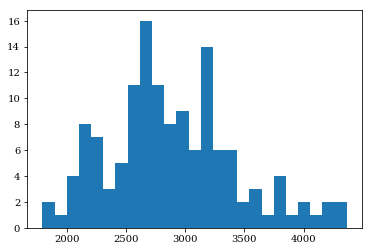

In [21]:
plt.hist(rss, bins=25);

In [22]:
print("Processed {0:.2E} events, {1:.2f} GB".format(df["nev_loaded"].sum(), df["data_loaded"].sum()))

Processed 8.93E+08 events, 701.18 GB


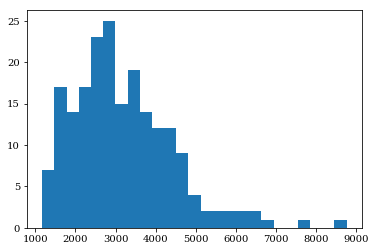

In [23]:
plt.hist(df["time"], bins=25);

In [24]:
df["time"].mean()

3189.8800995024867